In [182]:
# This code is written to support the experiments in the book titled:
# "Adaptive Machine Learning Algorithms"
# by
# Chanchal Chatterjee and Vwani P. Roychowdhury
# August 2021
#
# Experiments for Chapter 8 (NOAA.csv Data)
# EVD on semi-stationary and non-stationary data
# GEVD on semi-stationary and non-stationary data
#
# Author: Chanchal Chatterjee
#

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf


In [207]:
# Data obtained from USP DS Repository https://sites.google.com/view/uspdsrepository
# Load the data in your unique bucket.
# Here gs://chanchal_book_bucket1/NOAA.csv

In [186]:
#get data here: https://sites.google.com/view/uspdsrepository
dataset   = pd.read_csv("gs://chanchal_book_bucket1/NOAA.csv")
dataset = dataset.dropna()
print(dataset.shape)
print(dataset.head())


(18159, 9)
     F1    F2      F3   F4    F5    F6    F7    F8  Class
0  19.8  14.0  1019.6  8.4   9.9  15.9  28.9  14.0      1
1  26.8  22.2  1006.2  8.1  10.9  19.0  34.0  21.0      1
2  34.6  32.9  1004.6  3.9  13.8  22.0  36.0  33.1      2
3  26.4  21.5  1006.9  8.0  18.7  30.1  39.9  16.0      2
4  14.7   7.9  1009.9  8.1  14.1  22.0  21.0   9.0      1


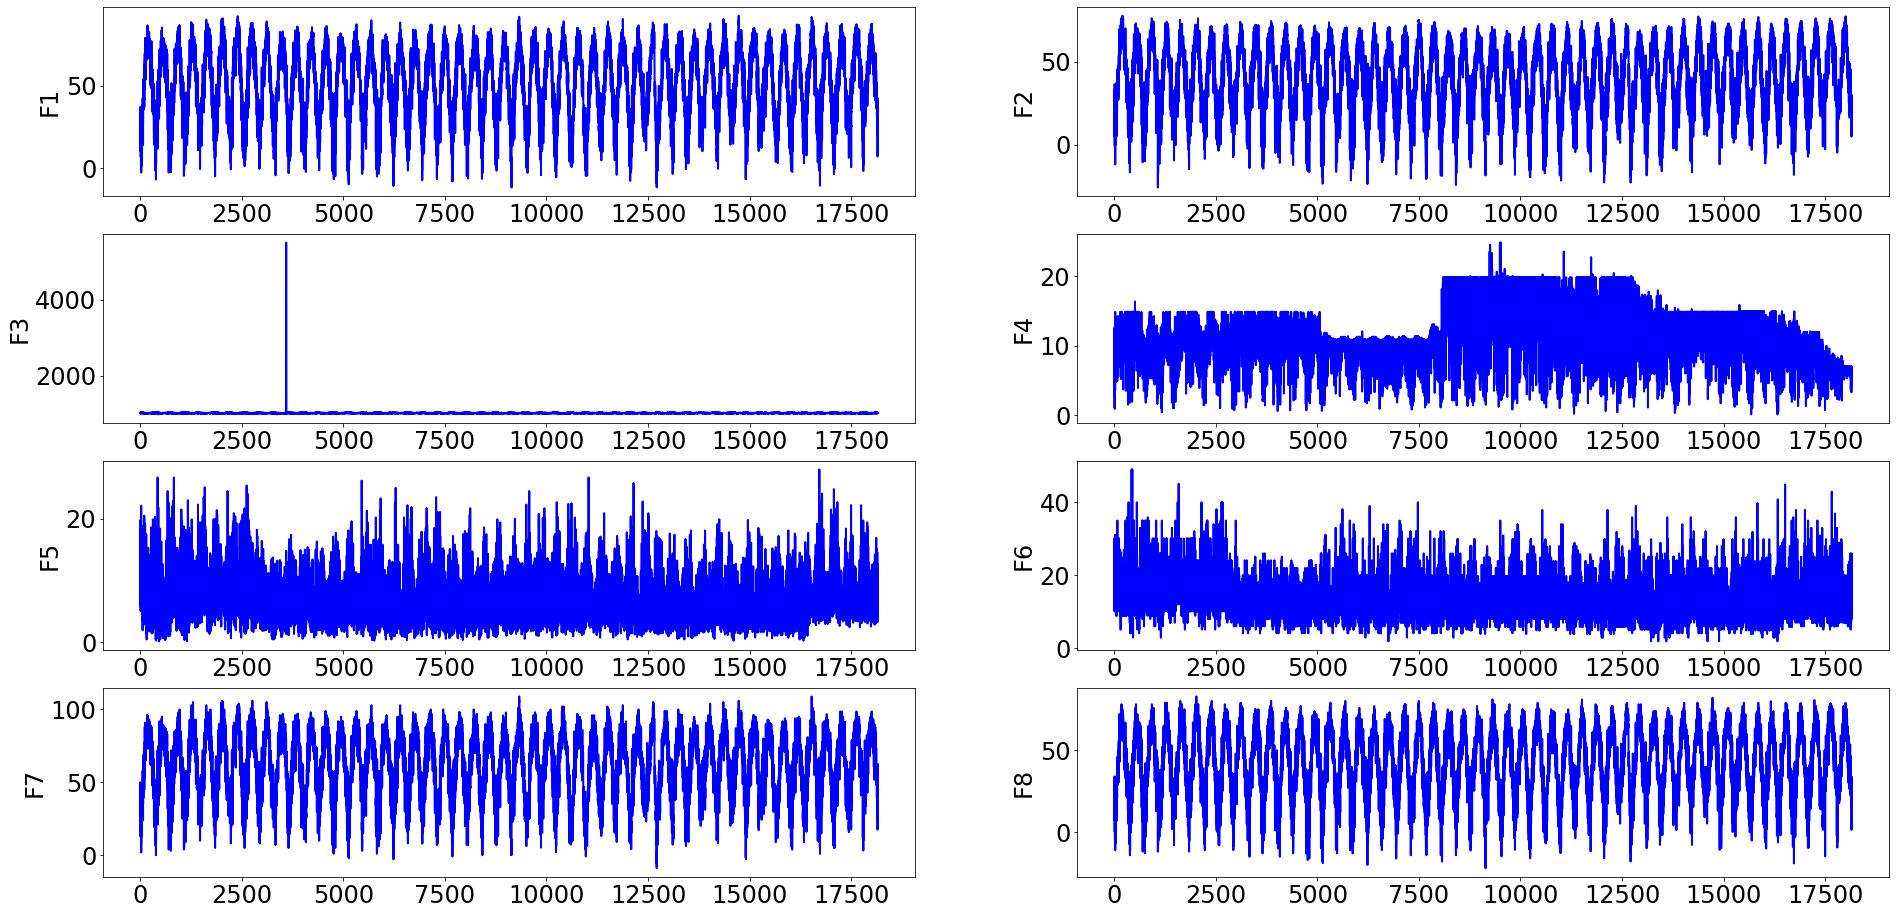

In [187]:
plt.figure(figsize=(32, 16))
plt.rcParams.update({'font.size': 24})
cols = dataset.columns
for i in range(2*(dataset.shape[1]//2)):
    plt.subplot(4, 2, i+1)
    plt.ylabel(cols[i])
    plt.plot(dataset[cols[i]], lw=2, color='b')
plt.show()


------------------------------------------
## Adaptive Linear Eigen Decomposition
### Using Semi-Stationary Components Only


In [188]:
dataset2 = dataset.drop(['F3', 'F4', 'Class'],1)
print(dataset2.shape)
print(dataset2.head())


(18159, 6)
     F1    F2    F5    F6    F7    F8
0  19.8  14.0   9.9  15.9  28.9  14.0
1  26.8  22.2  10.9  19.0  34.0  21.0
2  34.6  32.9  13.8  22.0  36.0  33.1
3  26.4  21.5  18.7  30.1  39.9  16.0
4  14.7   7.9  14.1  22.0  21.0   9.0


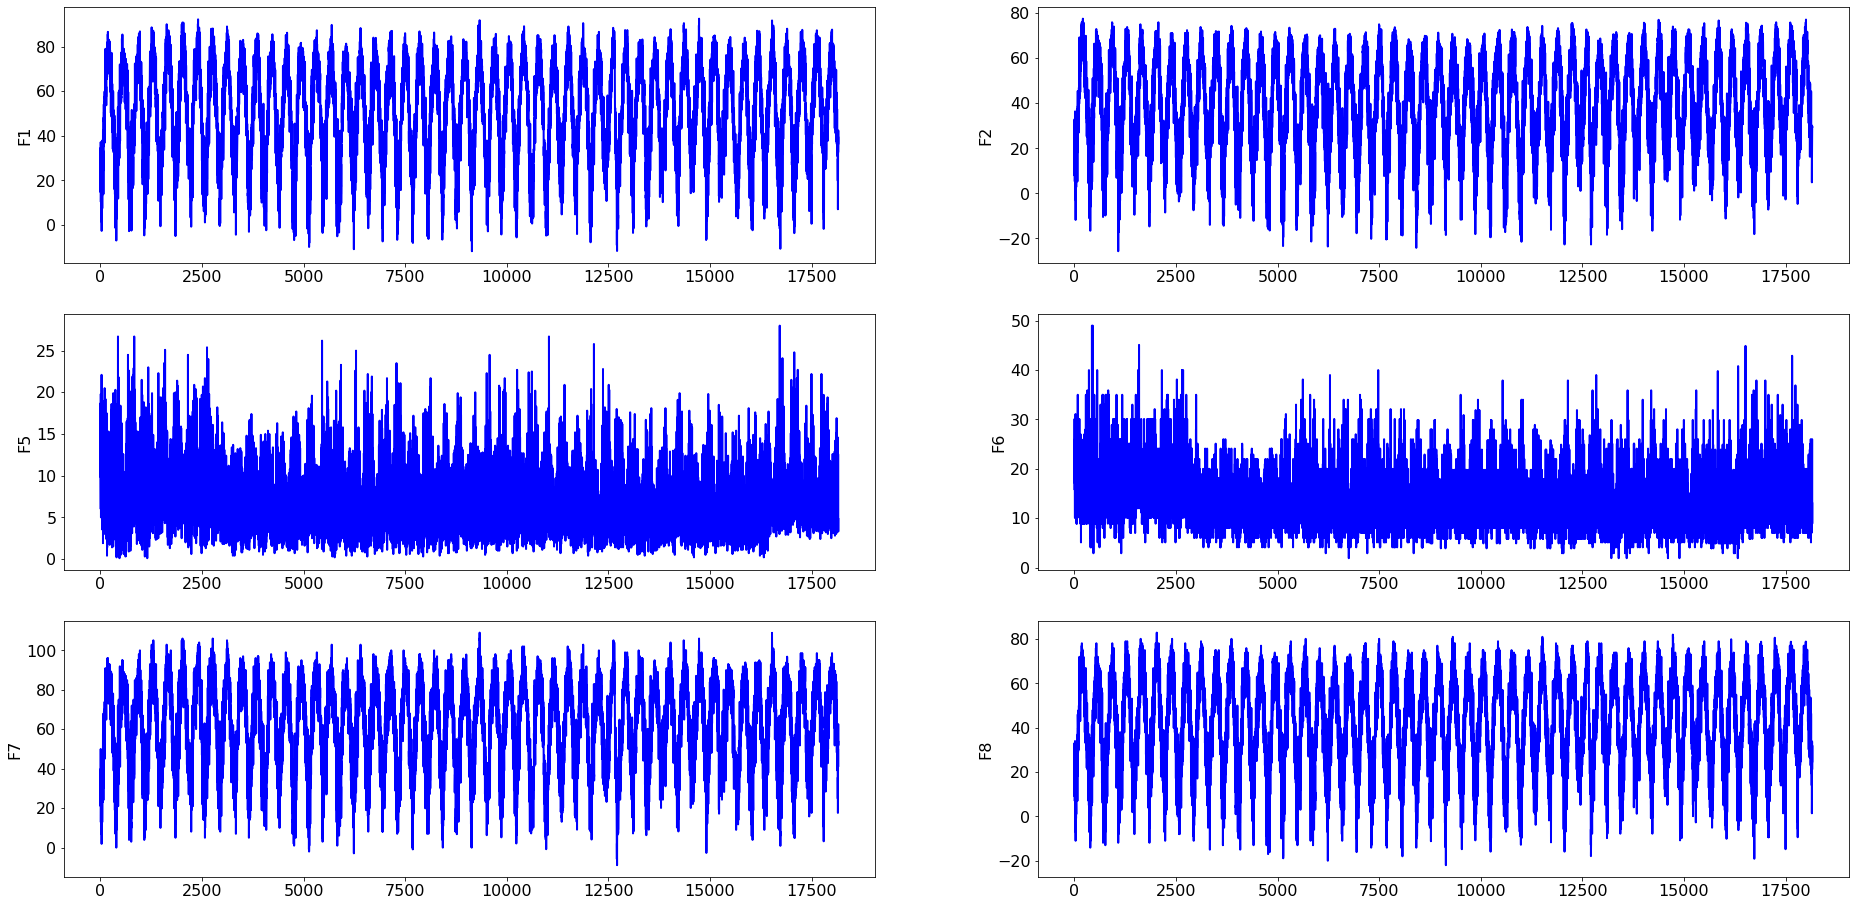

In [189]:
plt.figure(figsize=(32, 16))
plt.rcParams.update({'font.size': 16})
cols = dataset2.columns
for i in range(dataset2.shape[1]):
    plt.subplot(3, 2, i+1)
    plt.ylabel(cols[i])
    plt.plot(dataset2[cols[i]], lw=2, color='b')
plt.show()


In [190]:
# Adaptive algorithm
from numpy import linalg as la

nSamples = dataset2.shape[0]
nDim = dataset2.shape[1]

A = np.zeros(shape=(nDim,nDim)) # stores adaptive correlation matrix
N = np.zeros(shape=(1,nDim)) # stores eigen norms
W = 0.1 * np.ones(shape=(nDim,nDim)) # stores adaptive eigenvectors
for iter in range(nSamples//1):
    cnt = iter + 1
    x = np.array(dataset2.iloc[iter])
    x = x.reshape(nDim,1)
    A = A + (1.0/cnt)*((np.dot(x, x.T)) - A)
    etat = 1.0/(15000 + cnt)
    # Deflated Gradient Descent
    W = W + etat*(A @ W - 0.5*W @ np.triu(W.T @ A @ W) - 0.5*A @ W @ np.triu(W.T @ W))
    newnorm = la.norm(W, axis=0)
    N = np.vstack([N, newnorm])
print("W=\n", W)

W=
 [[ 0.50990917 -0.0391568   0.06797505 -0.00976783  0.27246233  0.20585742]
 [ 0.40807015 -0.4277626  -0.39071899  0.05301383 -0.6193636  -0.47691207]
 [ 0.05873081  0.36039534 -0.38854551  0.05914353  0.10504648  0.06987879]
 [ 0.11878986  0.66411396 -0.51660559  0.07937905 -0.08704717 -0.07782525]
 [ 0.60656148  0.38107016  0.57021874 -0.08019697 -0.18306697 -0.12165526]
 [ 0.433583   -0.31518118 -0.31575388  0.04402482  0.52820162  0.38880026]]


In [191]:
import math
from scipy.linalg import eigh
WTW = W.T @ W
WTAW = W.T @ A @ W
#print("WTW=\n", WTW)
#print("WTAW=\n", WTAW)
eigvals, eigvecs = eigh(A)
#print("PHI=\n", eigvecs)
print("Lambda=\n", eigvals)
print("Diags of WTAW")
print([WTAW[i,i] for i in range(len(WTAW[0]))])
print("Diags of WTW")
print([WTW[i,i] for i in range(len(WTW[0]))])


Lambda=
 [1.50074973e+00 2.89948694e+00 1.08152503e+01 3.91302561e+01
 1.09145583e+02 1.17167245e+04]
Diags of WTAW
[11716.724479546774, 109.1451169143686, 39.12949232638258, 0.828612489118598, 8.532502124953625, 4.848193061325381]
Diags of WTW
[1.0000000000194984, 0.9999998949144204, 0.9999808247373927, 0.02107460539420973, 0.7889694360838495, 0.4467278577506285]


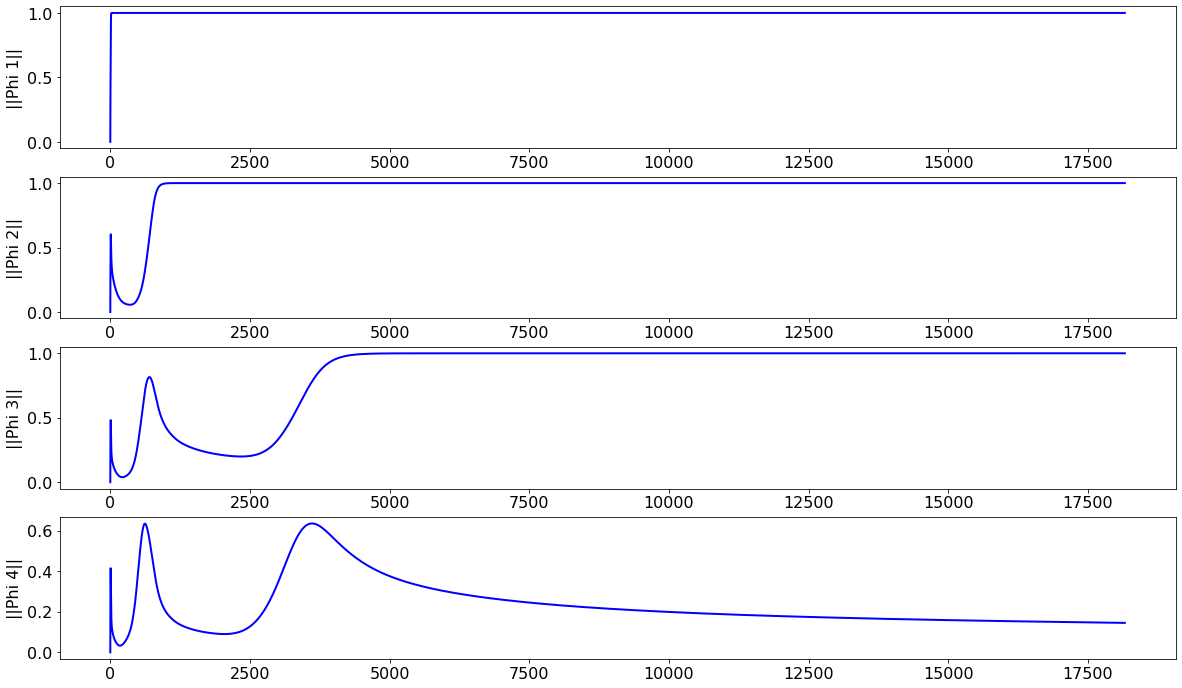

In [192]:
cols = dataset2.columns
norms = pd.DataFrame({cols[0]: N[:, 0], cols[1]: N[:, 1], cols[2]: N[:, 2], cols[3]: N[:, 3]})

plt.figure(figsize=(20, 12))
plt.rcParams.update({'font.size': 16})
cols = norms.columns
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.ylabel('||Phi {}||'.format(i+1))
    plt.plot(norms[cols[i]], lw=2, color='b')
plt.show()


------------------------------------------
## Adaptive Linear Eigen Decomposition
### Using all Non Stationary Components


In [193]:
dataset1 = dataset.drop(['Class'], 1)

print(dataset1.shape)
print(dataset1.head())


(18159, 8)
     F1    F2      F3   F4    F5    F6    F7    F8
0  19.8  14.0  1019.6  8.4   9.9  15.9  28.9  14.0
1  26.8  22.2  1006.2  8.1  10.9  19.0  34.0  21.0
2  34.6  32.9  1004.6  3.9  13.8  22.0  36.0  33.1
3  26.4  21.5  1006.9  8.0  18.7  30.1  39.9  16.0
4  14.7   7.9  1009.9  8.1  14.1  22.0  21.0   9.0


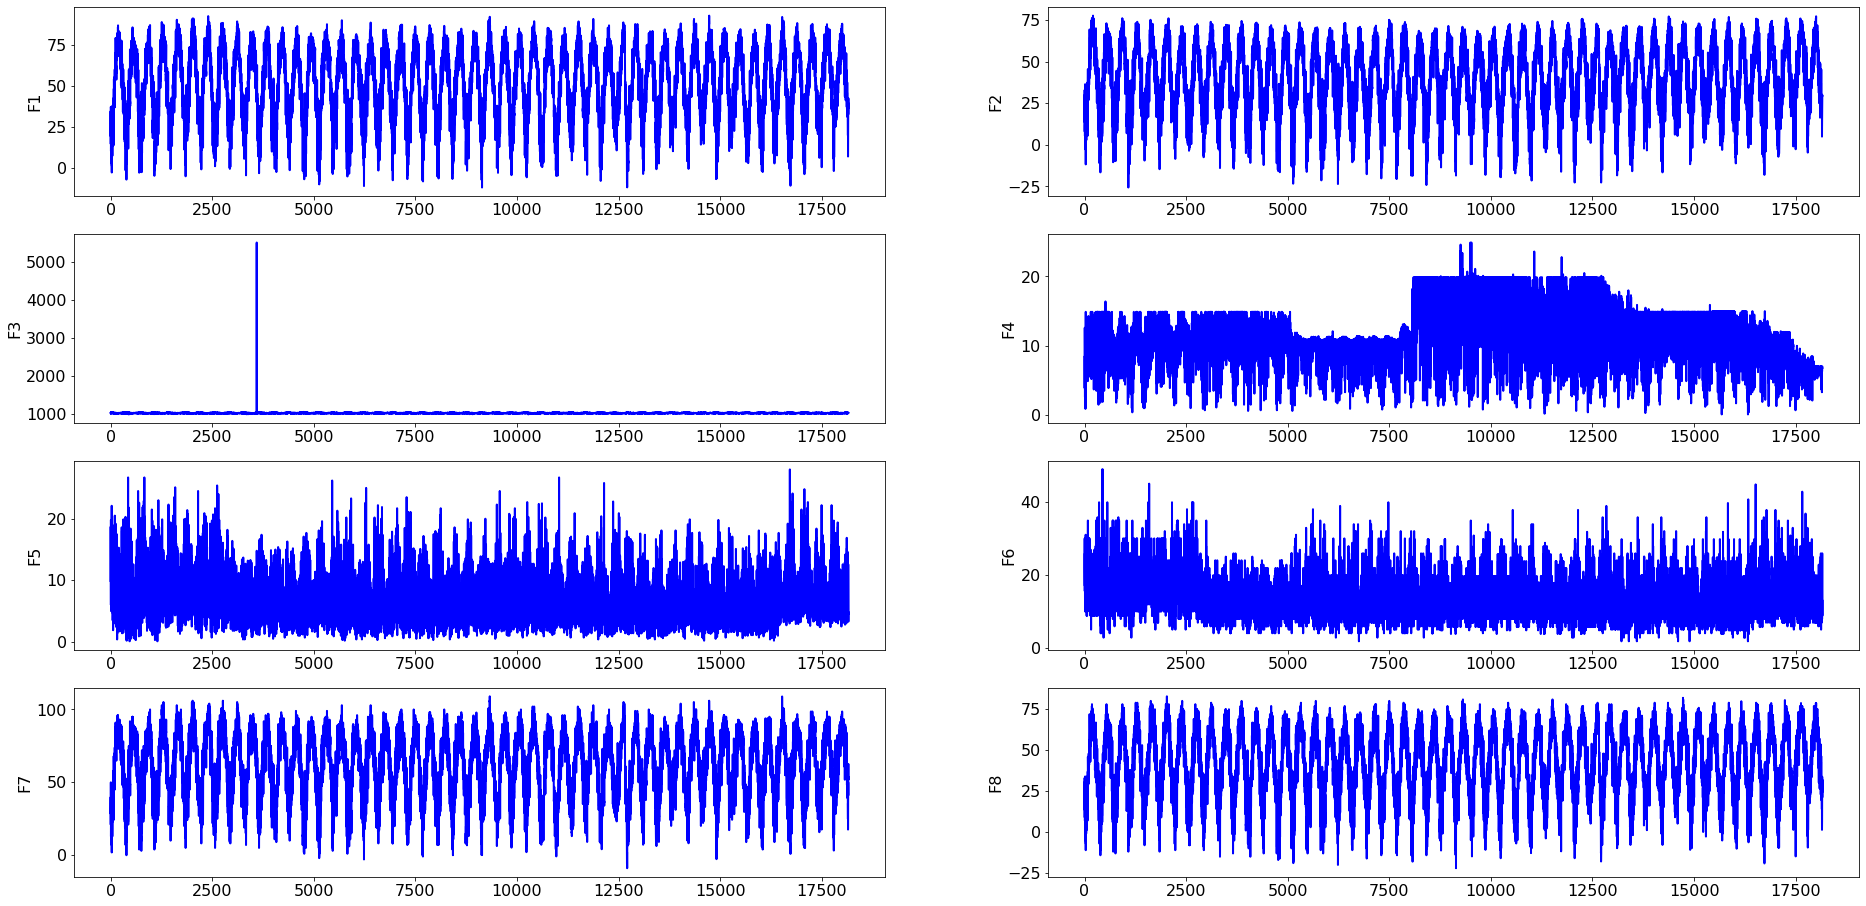

In [194]:
plt.figure(figsize=(32, 16))
plt.rcParams.update({'font.size': 16})
cols = dataset1.columns
for i in range(dataset1.shape[1]):
    plt.subplot(4, 2, i+1)
    plt.ylabel(cols[i])
    plt.plot(dataset1[cols[i]], lw=2, color='b')
plt.show()


In [195]:
# Adaptive algorithm
from numpy import linalg as la

nSamples = dataset1.shape[0]
nDim = dataset1.shape[1]

A = np.zeros(shape=(nDim,nDim)) # stores adaptive correlation matrix
N = np.zeros(shape=(1,nDim)) # stores eigen norms
W = 0.1 * np.ones(shape=(nDim,nDim)) # stores adaptive eigenvectors
for iter in range(nSamples//1):
    cnt = iter + 1
    x = np.array(dataset1.iloc[iter])
    x = x.reshape(nDim,1)
    A = A + (1.0/cnt)*((np.dot(x, x.T)) - A)
    etat = 1.0/(1500000 + cnt)
    # Deflated Gradient Descent
    W = W + etat*(A @ W - 0.5*W @ np.triu(W.T @ A @ W) - 0.5*A @ W @ np.triu(W.T @ W))
    newnorm = la.norm(W, axis=0)
    N = np.vstack([N, newnorm])
print("W=\n", W)

W=
 [[ 4.98220761e-02  5.07639874e-01  8.93325857e-02  3.38302222e-02
   1.77613740e-02  1.08760819e-02  7.26462352e-03  5.12230012e-03]
 [ 3.88052911e-02  4.72605746e-01  8.32789521e-02  3.33204557e-02
   1.93311579e-02  1.33116155e-02  9.99490016e-03  7.85197904e-03]
 [ 9.95116131e-01 -9.59553727e-02 -1.68983474e-02 -6.52065206e-03
  -3.60571432e-03 -2.40793994e-03 -1.81077563e-03 -1.47766010e-03]
 [ 1.13860384e-02  1.70536873e-02  4.34415873e-03  4.20964105e-03
   5.51917348e-03  7.06877329e-03  8.63174189e-03  1.01527676e-02]
 [ 6.84647804e-03 -9.08303721e-03 -9.28758098e-04  2.35256775e-03
   5.36687413e-03  8.14156989e-03  1.07023541e-02  1.30904454e-02]
 [ 1.36871334e-02 -8.32884623e-03 -8.58397435e-04  2.43181491e-03
   5.90584560e-03  9.19340843e-03  1.22265091e-02  1.50363402e-02]
 [ 6.05882969e-02  5.23104047e-01  9.14870105e-02  3.34433067e-02
   1.66661867e-02  9.56167994e-03  5.89222000e-03  3.75582388e-03]
 [ 4.14849346e-02  4.85445725e-01  8.57656450e-02  3.34082159e-02

In [196]:
import math
from scipy.linalg import eigh
WTW = W.T @ W
WTAW = W.T @ A @ W
#print("WTW=\n", WTW)
#print("WTAW=\n", WTAW)
eigvals, eigvecs = eigh(A)
#print("PHI=\n", eigvecs)
print("Lambda=\n", eigvals)
print("Diags of WTAW")
print([WTAW[i,i] for i in range(len(WTAW[0]))])
print("Diags of WTW")
print([WTW[i,i] for i in range(len(WTW[0]))])


Lambda=
 [1.49257112e+00 2.84211008e+00 7.88543533e+00 1.37357363e+01
 3.91646467e+01 4.52577018e+01 1.74315474e+03 1.04625874e+06]
Diags of WTAW
[1046258.7412009906, 1743.1450029343068, 53.938359206605185, 7.890913077110417, 2.2748453012699708, 0.9094217324750743, 0.44054560263929493, 0.24410569341481944]
Diags of WTW
[1.0000000000014757, 0.9999999619246012, 0.030947338976720737, 0.004560988634876559, 0.0014108753032824408, 0.000735016469621145, 0.0006013788785250283, 0.0006465017750780021]


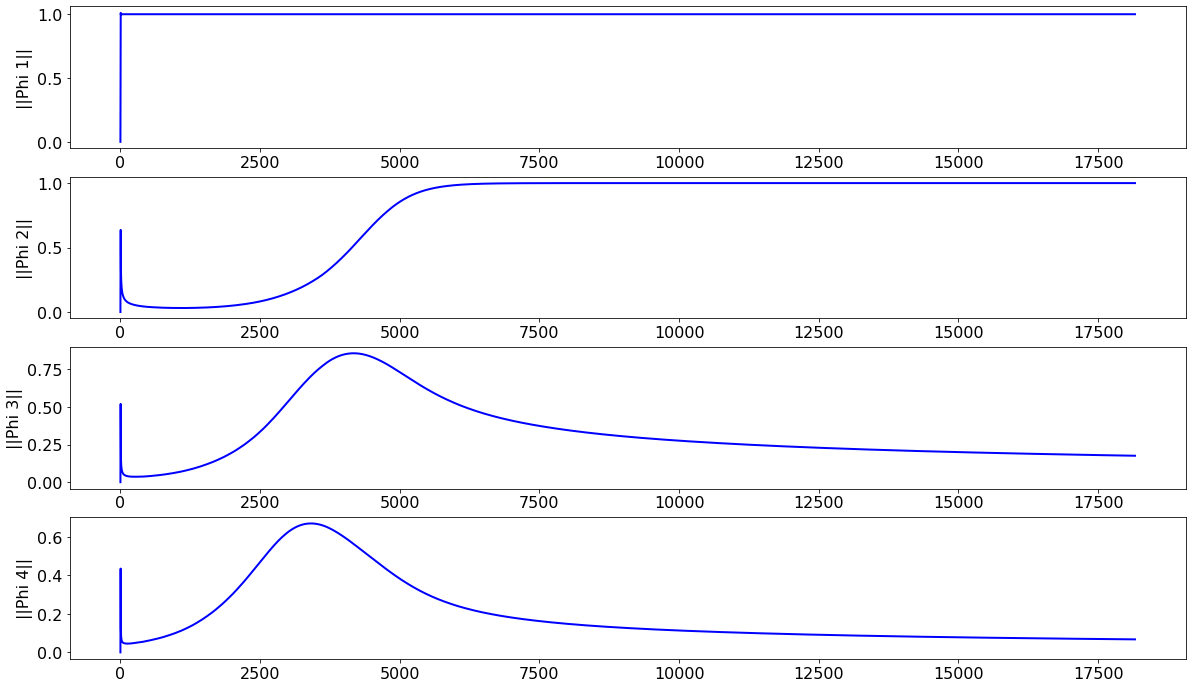

In [197]:
cols = dataset.columns
norms = pd.DataFrame({cols[0]: N[:, 0], cols[1]: N[:, 1], cols[2]: N[:, 2], cols[3]: N[:, 3], \
                      cols[4]: N[:, 4], cols[5]: N[:, 5], cols[6]: N[:, 6]})

plt.figure(figsize=(20, 12))
plt.rcParams.update({'font.size': 16})
cols = norms.columns
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.ylabel('||Phi {}||'.format(i+1))
    plt.plot(norms[cols[i]], lw=2, color='b')
plt.show()

------------------------------------------
## Adaptive Linear Generalized Eigen Decomposition
### Using Semi-Stationary Components Only

In [198]:
dataset2 = dataset.drop(['F3', 'F4', 'Class'],1)
print(dataset2.shape)
print(dataset2.head())


(18159, 6)
     F1    F2    F5    F6    F7    F8
0  19.8  14.0   9.9  15.9  28.9  14.0
1  26.8  22.2  10.9  19.0  34.0  21.0
2  34.6  32.9  13.8  22.0  36.0  33.1
3  26.4  21.5  18.7  30.1  39.9  16.0
4  14.7   7.9  14.1  22.0  21.0   9.0


In [199]:
# Adaptive algorithm
from numpy import linalg as la

nSamples = dataset2.shape[0]
nDim = dataset2.shape[1]

classes = np.array(dataset['Class']-1)
classes_categorical = tf.keras.utils.to_categorical(classes, num_classes=2)

M = np.zeros(shape=(nDim,2)) # stores adaptive correlation matrix
B = np.zeros(shape=(nDim,nDim)) # stores adaptive correlation matrix
N = np.zeros(shape=(1,nDim)) # stores eigen norms
W = 0.1 * np.ones(shape=(nDim,nDim)) # stores adaptive eigenvectors
for iter in range(nSamples//1):
    cnt = iter + 1
    x = np.array(dataset2.iloc[iter])
    x = x.reshape(nDim,1)
    B = B + (1.0/cnt)*((np.dot(x, x.T)) - B)
    y = classes_categorical[iter].reshape(2,1)
    M = M + (1.0/cnt)*((np.dot(x, y.T)) - M)
    A = M @ M.T
    etat = 1.0/(1000000 + cnt)
    # Deflated Gradient Descent
    W = W + etat*(A @ W - 0.5* B @ W @ np.triu(W.T @ A @ W) - 0.5*A @ W @ np.triu(W.T @ B @ W))
    WTBW = W.T @ B @ W
    newnorm = [math.sqrt(WTBW[i,i]) for i in range(len(WTBW[0]))]
    N = np.vstack([N, newnorm])
print("W=\n", W)


W=
 [[ 0.00219472 -0.00402896 -0.00224618 -0.00136506 -0.00069326 -0.00012216]
 [ 0.01587257  0.02751324  0.028075    0.02945368  0.03092547  0.03227054]
 [ 0.05402234  0.05039545  0.04910082  0.0479527   0.04678838  0.04563372]
 [ 0.02664047  0.01663786  0.01632902  0.01563841  0.01480055  0.0139634 ]
 [-0.02239154 -0.05009913 -0.04769303 -0.04812022 -0.04912509 -0.05020342]
 [ 0.01938049  0.02862873  0.02876769  0.029548    0.03040676  0.03114976]]


In [200]:
import math
from scipy.linalg import eigh
WTAW = W.T @ A @ W
WTBW = W.T @ B @ W
print("WTBW=\n", WTBW)
print("WTAW=\n", WTAW)
eigvals, eigvecs = eigh(A, B)
print("PHI=\n", eigvecs)
print("Lambda=\n", eigvals)
print("Diags of WTAW")
print([math.sqrt(WTAW[i,i]) for i in range(len(WTAW[0]))])
print("Diags of WTBW")
print([math.sqrt(WTBW[i,i]) for i in range(len(WTBW[0]))])


WTBW=
 [[ 1.0669285  -0.23248712  0.02390997  0.117554    0.16990703  0.20208131]
 [-0.23248712  0.42070193  0.29974126  0.25968511  0.23932063  0.22770899]
 [ 0.02390997  0.29974126  0.25483072  0.24286848  0.23854288  0.23709221]
 [ 0.117554    0.25968511  0.24286848  0.24169398  0.24378461  0.24656019]
 [ 0.16990703  0.23932063  0.23854288  0.24378461  0.24984819  0.25533561]
 [ 0.20208131  0.22770899  0.23709221  0.24656019  0.25533561  0.26272977]]
WTAW=
 [[ 0.44603408 -0.22183357 -0.09676476 -0.05387934 -0.03151713 -0.01870128]
 [-0.22183357  0.14175726  0.07565224  0.05381964  0.04296467  0.0370833 ]
 [-0.09676476  0.07565224  0.04510132  0.03535641  0.03073872  0.02838978]
 [-0.05387934  0.05381964  0.03535641  0.02974294  0.02727106  0.02614645]
 [-0.03151713  0.04296467  0.03073872  0.02727106  0.02592259  0.02544469]
 [-0.01870128  0.0370833   0.02838978  0.02614645  0.02544469  0.02534274]]
PHI=
 [[-0.29692881  0.02762153  0.28142255 -0.45208976 -0.22465521 -0.04841457]
 [-

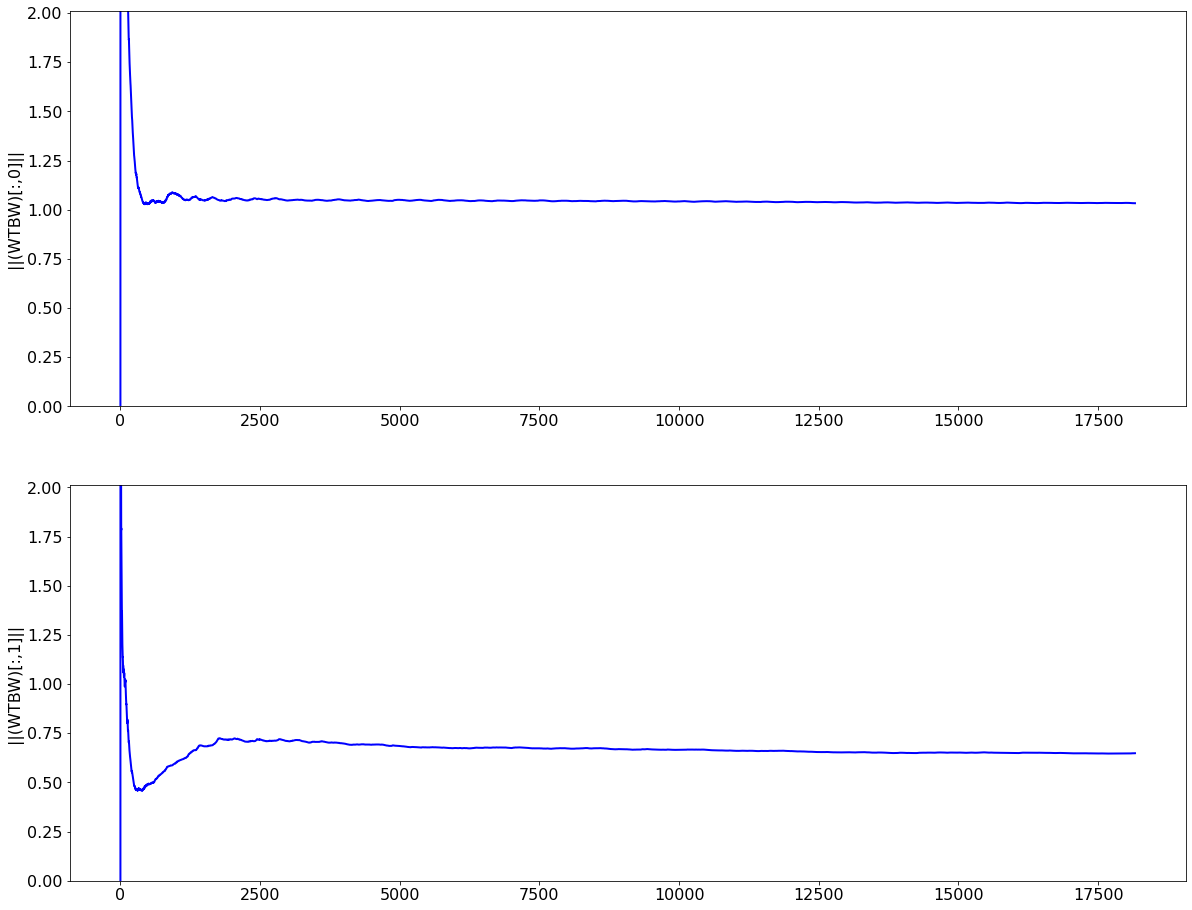

In [201]:
cols = dataset2.columns
norms = pd.DataFrame({cols[0]: N[:, 0], cols[1]: N[:, 1], cols[2]: N[:, 2], cols[3]: N[:, 3], \
                      cols[4]: N[:, 4], cols[5]: N[:, 5]})

plt.figure(figsize=(20, 16))
plt.rcParams.update({'font.size': 16})
cols = norms.columns
for i in range(2):
    plt.subplot(2, 1, i+1)
    plt.ylabel('||(WTBW)[:,{}]||'.format(i))
    plt.ylim([0,2.01])
    plt.plot(norms[cols[i]], lw=2, color='b')
plt.show()


------------------------------------------
## Adaptive Linear Generalized Eigen Decomposition
### Using All Non Stationary Components


In [202]:
dataset1 = dataset.drop(['Class'],1)
print(dataset1.shape)
print(dataset1.head())

(18159, 8)
     F1    F2      F3   F4    F5    F6    F7    F8
0  19.8  14.0  1019.6  8.4   9.9  15.9  28.9  14.0
1  26.8  22.2  1006.2  8.1  10.9  19.0  34.0  21.0
2  34.6  32.9  1004.6  3.9  13.8  22.0  36.0  33.1
3  26.4  21.5  1006.9  8.0  18.7  30.1  39.9  16.0
4  14.7   7.9  1009.9  8.1  14.1  22.0  21.0   9.0


In [203]:
# Adaptive algorithm
from numpy import linalg as la

nSamples = dataset1.shape[0]
nDim = dataset1.shape[1]

classes = np.array(dataset['Class']-1)
classes_categorical = tf.keras.utils.to_categorical(classes, num_classes=2)

M = np.zeros(shape=(nDim,2)) # stores adaptive correlation matrix
B = np.zeros(shape=(nDim,nDim)) # stores adaptive correlation matrix
N = np.zeros(shape=(1,nDim)) # stores eigen norms
W = 0.1 * np.ones(shape=(nDim,nDim)) # stores adaptive eigenvectors
for iter in range(nSamples//1):
    cnt = iter + 1
    x = np.array(dataset1.iloc[iter])
    x = x.reshape(nDim,1)
    B = B + (1.0/cnt)*((np.dot(x, x.T)) - B)
    y = classes_categorical[iter].reshape(2,1)
    M = M + (1.0/cnt)*((np.dot(x, y.T)) - M)
    A = M @ M.T
    etat = 1.0/(100000000000 + cnt)
    # Deflated Gradient Descent
    W = W + etat*(A @ W - 0.5* B @ W @ np.triu(W.T @ A @ W) - 0.5*A @ W @ np.triu(W.T @ B @ W))
    WTBW = W.T @ B @ W
    newnorm = [math.sqrt(WTBW[i,i]) for i in range(len(WTBW[0]))]
    N = np.vstack([N, newnorm])
print("W=\n", W)


W=
 [[ 0.09629384  0.09661391  0.09676528  0.09683207  0.0968718   0.09691073
   0.09695542  0.09700353]
 [ 0.09704862  0.09731577  0.09744198  0.09750235  0.09754186  0.09758069
   0.09762383  0.09766941]
 [-0.02090455 -0.02145736 -0.02087136 -0.02096609 -0.02124812 -0.02140336
  -0.02138604 -0.02127097]
 [ 0.09895249  0.09898112  0.09899712  0.09899938  0.09899788  0.09899748
   0.09899903  0.09900165]
 [ 0.0987494   0.09872563  0.09873698  0.09874984  0.09876298  0.09877735
   0.09879297  0.09880926]
 [ 0.09784054  0.09784234  0.09788432  0.09792159  0.09795684  0.09799368
   0.09803273  0.09807301]
 [ 0.09516165  0.09552251  0.09569774  0.09577012  0.09580867  0.09584587
   0.09589013  0.09593883]
 [ 0.09713691  0.09740413  0.09751974  0.0975663   0.09759164  0.09761686
   0.09764689  0.09767957]]


In [204]:
import math
from scipy.linalg import eigh
WTAW = W.T @ A @ W
WTBW = W.T @ B @ W
print("WTBW=\n", WTBW)
print("WTAW=\n", WTAW)
eigvals, eigvecs = eigh(A, B)
print("PHI=\n", eigvecs)
print("Lambda=\n", eigvals)
print("Diags of WTAW")
print([math.sqrt(WTAW[i,i]) for i in range(len(WTAW[0]))])
print("Diags of WTBW")
print([math.sqrt(WTBW[i,i]) for i in range(len(WTBW[0]))])


WTBW=
 [[66.47868157 66.34320171 66.86688072 66.85179793 66.6855158  66.60667812
  66.65216877 66.76820759]
 [66.34320171 66.46037504 66.6702251  66.6972145  66.67129676 66.66808838
  66.70046699 66.75310544]
 [66.86688072 66.6702251  67.27181606 67.24658564 67.04582273 66.94846431
  66.997337   67.12917031]
 [66.85179793 66.6972145  67.24658564 67.22836201 67.05096274 66.96619402
  67.01288758 67.13417251]
 [66.6855158  66.67129676 67.04582273 67.05096274 66.95167143 66.90897303
  66.94832892 67.03427733]
 [66.60667812 66.66808838 66.94846431 66.96619402 66.90897303 66.88893618
  66.92434473 66.99126691]
 [66.65216877 66.70046699 66.997337   67.01288758 66.94832892 66.92434473
  66.96045612 67.0307164 ]
 [66.76820759 66.75310544 67.12917031 67.13417251 67.03427733 66.99126691
  67.0307164  67.11698839]]
WTAW=
 [[1.38242806 1.33474485 1.4008933  1.3931285  1.36490552 1.34992579
  1.35318472 1.3667804 ]
 [1.33474485 1.43127713 1.31840636 1.33466277 1.38653585 1.41471821
  1.41050981 1.3

In [205]:
cols = dataset1.columns
norms = pd.DataFrame({cols[0]: N[:, 0], cols[1]: N[:, 1], cols[2]: N[:, 2], cols[3]: N[:, 3], \
                      cols[4]: N[:, 4], cols[5]: N[:, 5], cols[6]: N[:, 6], cols[7]: N[:, 7]})

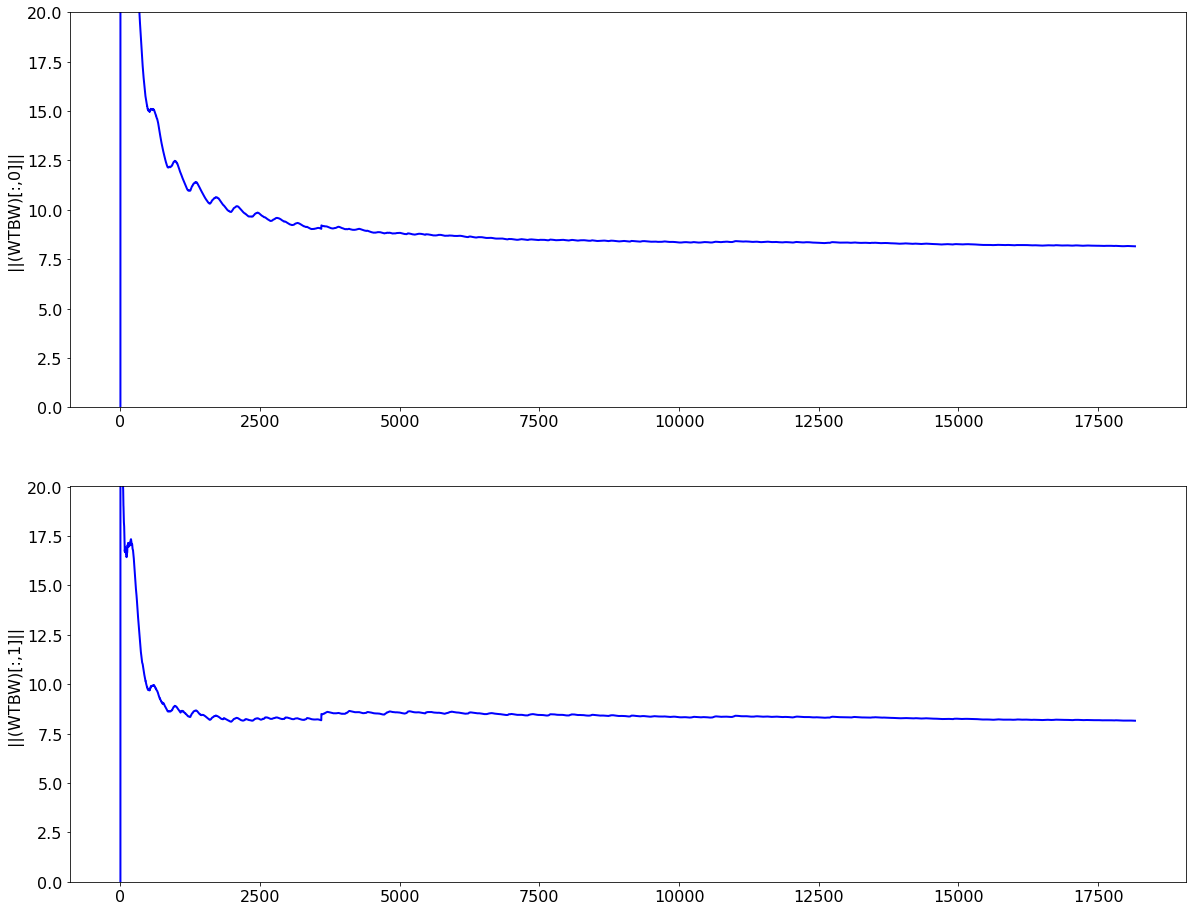

In [206]:
plt.figure(figsize=(20, 16))
plt.rcParams.update({'font.size': 16})
cols = norms.columns
for i in range(2):
    plt.subplot(2, 1, i+1)
    plt.ylabel('||(WTBW)[:,{}]||'.format(i))
    plt.ylim([0,20.01])
    plt.plot(norms[cols[i]], lw=2, color='b')
plt.show()
